In [1]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

### Create the Data Generating Process

In [2]:
# Simulate S1 and S2

def simulate_S1_S2(num_points1, num_points2): 
    np.random.seed(26) # set random seed
    
    locations1 = np.random.rand(num_points1, 2) * 100
    locations2 = np.random.rand(num_points2, 2) * 200

    s1 = np.random.normal(50, 10, num_points1)  # Target support observations
    s2 = np.random.normal(100, 50, num_points2) # Source support observations

    return s1, locations1, s2, locations2

S1, loc1, S2, loc2 = simulate_S1_S2(100, 150)

def create_surface(locations):
    x = locations[:, 0]
    y = locations[:, 1]
    B = x + y  # True beta surface defined on target support S1
    return B

B = create_surface(loc1)

# Number of neighbors for smoothing (DGP-specific)
n_neighbor_dgp = 10

smoothed_S2_to_S1 = np.zeros(len(S1))

# Use KNN to smooth X values from S2 onto S1
nbrs_S2 = NearestNeighbors(n_neighbors=n_neighbor_dgp).fit(loc2)

for i in range(len(S1)):
    # Find neighbors of S1 location i in S2
    distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc1[i]])

    # Aggregate the X values from S2 using a simple mean for the DGP (this is not the regression step)
    smoothed_S2_to_S1[i] = np.mean(S2[indices_S1_to_S2[0]])

y = B * smoothed_S2_to_S1  

### Modelling and Change of Support Step

Select observations of S2 that are near to each location of S1_i 



For each i location in S1_i, compute weights based on the distances between S2 and the Specific i location. Apply the computed weights to the selected S2 observations. 


Use the weighted X values from S2 for regression at S1_i, also the corresponding y values at S1_i to then calculate weighted regression coefficient for the local point.

In [5]:
# Number of neighbors for regression (estimator-specific)
n_neighbor_est = 20
recovered_betas = np.zeros(len(S1))

for i in range(len(S1)):
    local_X = []
    weights_X = []
    
    # Initialize Nearest Neighbors model to find neighbors in S2 for current S1_i
    nbrs_S2 = NearestNeighbors(n_neighbors=n_neighbor_est).fit(loc2)
    distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc1[i]])
    
    # Compute weights for the selected neighbors in S2 based on distance to S1_i
    for j, neighbor_index_S2 in enumerate(indices_S1_to_S2[0]):
        dist_j_to_i = distances_S1_to_S2[0][j]  # Distance from S2 neighbor j to S1 location i
        
        # Compute weight using a gaussian kernel
        weight = np.exp(-0.5 * (dist_j_to_i / 10)**2)
        
        # Collect S2 observation and its weight
        local_X.append(S2[neighbor_index_S2])
        weights_X.append(weight)
    
    # Convert lists to numpy arrays for further processing
    local_X = np.array(local_X)
    weights_X = np.array(weights_X)

    # Apply the computed weights to the selected S2 observations (X values)
    # This effectively smooths the S2 observations towards S1_i
    weighted_X_i = np.sum(local_X * weights_X) / np.sum(weights_X)

    # Perform local regression using the weighted S2 data at S1_i
    # Initialize Nearest Neighbors model to find neighbors in S1 for current S1_i
    nbrs_S1 = NearestNeighbors(n_neighbors=n_neighbor_est).fit(loc1)
    distances, indices = nbrs_S1.kneighbors([loc1[i]])

    # Obtain y values of neighbors in S1
    y_neighbors = y[indices[0]]
    
    # Use the same weighted X value for all neighbors
    X_neighbors = weighted_X_i * np.ones(len(indices[0]))

    # Compute regression weights based on distances between neighbors in S1
    weights_y = np.exp(-0.5 * (distances[0] / 10)**2)  # Gaussian kernel
    W_y = np.sqrt(weights_y)

    # Prepare weighted datasets for local regression
    X_weighted = (X_neighbors * W_y).reshape(-1, 1)
    y_weighted = y_neighbors * W_y

    # Fit weighted linear regression
    model = LinearRegression()
    model.fit(X_weighted, y_weighted)

    # Store recovered beta
    recovered_beta = model.coef_[0]
    recovered_betas[i] = recovered_beta
    
# Output the results
print("\nFirst 5 recovered betas compared to true betas:")
print(f"True betas: {B[:5]}")
print(f"Recovered betas: {recovered_betas[:5]}")



First 5 recovered betas compared to true betas:
True betas: [ 82.73264319 155.75183977 105.84834541  76.56973866  93.40737388]
Recovered betas: [ 87.761245   144.14596384 128.74754969  80.59463954 103.11578396]


In [6]:
def plot_results(true_B, estimated_B):
    plt.figure(figsize=(8, 6))
    plt.scatter(true_B, estimated_B, color='blue', label='Estimated vs True Betas')
    plt.plot([min(true_B), max(true_B)], [min(true_B), max(true_B)], color='red', linestyle='--', label='1:1 Line')
    plt.xlabel('True Betas')
    plt.ylabel('Estimated Betas')
    plt.title('True vs Estimated Betas')
    plt.legend()
    plt.grid(True)
    plt.show()

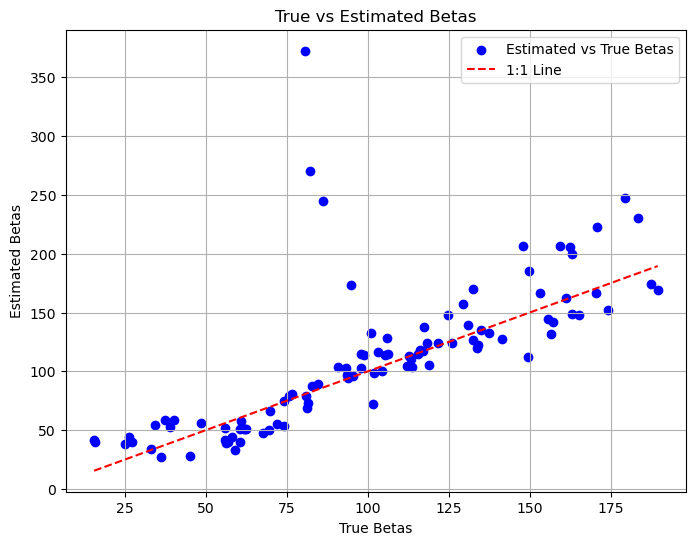

In [7]:
plot_results(B, recovered_betas)